In [35]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

3.10.9


In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [3]:
# Run a DMRG calculation to get the entanglement profile of the ground state:

dmrg1 = GenSubspace(chemical_data, 1, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));
dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt)]
GenStates!(dmrg1)
GenPermOps!(dmrg1)
GenSubspaceMats!(dmrg1)

biparts, entrops = ComputeBipartites(dmrg1, state=1);

In [4]:
# Get quasi-optimal orderings via simulated annealing:

tnqe0 = GenSubspace(chemical_data, 5, psi_maxdim=3, sweep_num=6, sweep_noise=(1e-6), thresh="projection", eps=1e-12);

gp = GeomParameters(
    costfunc = "simple",
    zeta_list = [0.03],
    a_maxiter=5000
)

tnqe0.ord_list = BipartiteAnnealing(
    [randperm(tnqe0.chem_data.N_spt) for j=1:tnqe0.mparams.M], 
    biparts, 
    entrops, 
    tnqe0.mparams.psi_maxdim,
    gp,
    verbose=true
)

5-element Vector{Any}:
 [1, 5, 3, 7, 2, 4, 6]
 [7, 3, 4, 6, 2, 5, 1]
 [3, 7, 5, 6, 4, 1, 2]
 [1, 5, 2, 4, 6, 7, 3]
 [5, 2, 6, 3, 7, 1, 4]

In [37]:
# Initialize the states:
opt_sweeps = Sweeps(15)
maxdim!(opt_sweeps,tnqe0.mparams.psi_maxdim)
mindim!(opt_sweeps,tnqe0.mparams.psi_maxdim)
cutoff!(opt_sweeps,1e-12)
setnoise!(opt_sweeps, 1e-1,1e-1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-12,0.0)

GenHams!(tnqe0)
GenSLocHams!(tnqe0, sl_base=1e6)

#GenExcited!(tnqe0, sweeps=opt_sweeps, weight=, levs=collect(1:tnqe0.mparams.M), verbose=true);
#GenSLocStates!(tnqe0, sweeps=opt_sweeps, verbose=true);
GenStates!(tnqe0, randomize=true, verbose=true)

Generating states:
Progress: [5/5] 
Done!


Generating permutation operators:
Progress: [10/10] 
Done!

Minimum eigenvalue: -82.26478574678477
Condition number: 1.294340728192052
FCI energy: -75.01927599660624
Final energy estimate: -73.42376557777385
Best single ref. estimate: -73.42241872328157
Error: 1.59551041883239
BSRfE: 1.596857273324673
Improvement: 0.0013468544922830006
Percentage error reduction: 0.08434407475120402
Eigenvalue condition numbers: [0.0122, 0.0123, 0.012, 0.013, 0.0135]
Percent correlation energy with single-geometry DMRG: -2648.2336382766716
Percent correlation energy with multi-geometry TNQE: -2645.915666042466


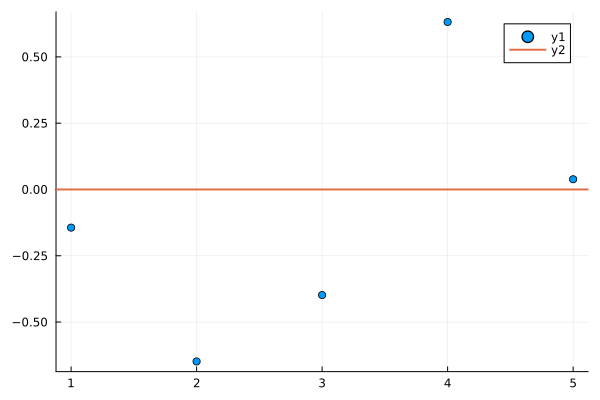

In [38]:
GenPermOps!(tnqe0, verbose=true)
GenSubspaceMats!(tnqe0)
SolveGenEig!(tnqe0, verbose=true)

In [39]:
tnqe1 = copy(tnqe0)

op1 = OptimParameters(
    maxiter=1, 
    numloop=2, 
    noise=[1e-2], 
    sd_thresh="inversion", 
    sd_eps=1.0e-8,
    delta=[1e-3]
)

op2 = OptimParameters(
    afunc="exp",
    alpha=2e4,
    rnum=1
)

"""
GeneralizedTwoSite!(
    tnqe1, 
    op1, 
    verbose=true
)
"""

"""
RandomSiteDecomp!(
    tnqe1, 
    op2, 
    verbose=true
)
"""


MultiGeomOptim!(
    tnqe1,
    [op2, op1],
    reps = 4,
    rep_struct = [
        ["recycle", 1],
        ["twosite", 2]
    ],
    verbose=true
)



########## Starting MultiGeomOptim!


########## Repetition 1/4:

Recycling states...


GENERALIZED TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; state: 5/5; sweep: 2/2; bond: 6/6; E_min = -83.85963; kappa = 12.9     
Done!


########## Repetition 1/4 complete!
########## E_new = -83.8596314174802; E_best = -83.8596314174802
########## Outcome = "accept!"; acceptance ratio = 100%


########## Repetition 2/4:

Recycling states...


GENERALIZED TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; state: 5/5; sweep: 2/2; bond: 6/6; E_min = -83.85973; kappa = 5.45     
Done!


########## Repetition 2/4 complete!
########## E_new = -83.85973344584258; E_best = -83.85973344584258
########## Outcome = "accept!"; acceptance ratio = 100%


########## Repetition 3/4:

Recycling states...


GENERALIZED TWO-SITE SWEEP ALGORITHM:
Iter: 1/1; state: 5/5; sweep: 2/2; bond: 6/6; E_min = -83.85999; kappa = 9.01     
Done!


########## Repetition 3/4 complete!
########## E_new = -83.8599927925245; E_best = -83.8599927925245
###